In [12]:
import numpy as np
import pydensecrf.densecrf as dcrf
import matplotlib.pyplot as plt
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
import cv2
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from osgeo import gdal
import os
%matplotlib inline


In [18]:
mask_path = '/data1/ian/share_code/result_mask_new1/'
WSI_path = '/data1/ian/C16_training_small/testing'
files = os.listdir(mask_path)
for f in files:
    if 'probas' in f:
        print(f)
        mask = os.path.join(mask_path, f)  
        y = cv2.imread(mask)
        WSI = os.path.join(WSI_path,f[:-11] + '.png')
        print(WSI)
        X=cv2.imread(WSI)
        x_size = X.size
        y_size = y.size

        X = cv2.resize(X, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        y = cv2.resize(y, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

test_022_probas.png
/data1/ian/C16_training_small/testing/test_022.png
test_119_probas.png
/data1/ian/C16_training_small/testing/test_119.png
test_092_probas.png
/data1/ian/C16_training_small/testing/test_092.png
test_124_probas.png
/data1/ian/C16_training_small/testing/test_124.png
test_123_probas.png
/data1/ian/C16_training_small/testing/test_123.png
test_015_probas.png
/data1/ian/C16_training_small/testing/test_015.png
test_063_probas.png
/data1/ian/C16_training_small/testing/test_063.png
test_034_probas.png
/data1/ian/C16_training_small/testing/test_034.png
test_072_probas.png
/data1/ian/C16_training_small/testing/test_072.png
test_101_probas.png
/data1/ian/C16_training_small/testing/test_101.png
test_007_probas.png
/data1/ian/C16_training_small/testing/test_007.png
test_058_probas.png
/data1/ian/C16_training_small/testing/test_058.png
test_094_probas.png
/data1/ian/C16_training_small/testing/test_094.png
test_026_probas.png
/data1/ian/C16_training_small/testing/test_026.png
test_0

test_062_probas.png
/data1/ian/C16_training_small/testing/test_062.png
test_029_probas.png
/data1/ian/C16_training_small/testing/test_029.png
test_055_probas.png
/data1/ian/C16_training_small/testing/test_055.png
test_006_probas.png
/data1/ian/C16_training_small/testing/test_006.png
test_109_probas.png
/data1/ian/C16_training_small/testing/test_109.png
test_040_probas.png
/data1/ian/C16_training_small/testing/test_040.png
test_051_probas.png
/data1/ian/C16_training_small/testing/test_051.png
test_090_probas.png
/data1/ian/C16_training_small/testing/test_090.png
test_021_probas.png
/data1/ian/C16_training_small/testing/test_021.png
test_125_probas.png
/data1/ian/C16_training_small/testing/test_125.png
test_115_probas.png
/data1/ian/C16_training_small/testing/test_115.png
test_112_probas.png
/data1/ian/C16_training_small/testing/test_112.png


In [7]:
"""
Function which returns the labelled image after applying CRF

"""

#Original_image = Image which has to labelled
#Annotated image = Which has been labelled by some technique( FCN in this case)
#Output_image = Name of the final output image after applying CRF
#Use_2d = boolean variable 
#if use_2d = True specialised 2D fucntions will be applied
#else Generic functions will be applied

def crf(original_image, annotated_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image).astype(np.uint32)
    
    cv2.imwrite("testing2.png",annotated_image)
    annotated_image = annotated_image.astype(np.uint32)
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0].astype(np.uint32) + (annotated_image[:,:,1]<<8).astype(np.uint32) + (annotated_image[:,:,2]<<16).astype(np.uint32)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
    print("No of labels in the Image are ")
    print(n_labels)
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.90, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(5)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    #cv2.imwrite(output_image,MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape)


In [8]:
crfimage = crf(X,y,"out.png")

No of labels in the Image are 
256


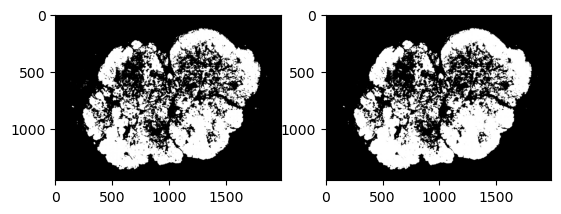

In [9]:
plt.subplot(1,2,1)
plt.imshow(y)
plt.subplot(1,2,2)
plt.imshow(crfimage)